As usual, we import Pandas and Numpy.  I'm also going to use a nice function called MonthEnd, which I will explain below.

In [1]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt

As I did in the smart beta notebook, I will use a function for computing weighted averages.  This will be used to construct returns on cap-weighted portfolios:

In [2]:
def weighted_average(df,data_col,weight_col,by_col):
    df['_data_times_weight'] = df[data_col]*df[weight_col]
    df['_weight_where_notnull'] = df[weight_col]*pd.notnull(df[data_col])
    g = df.groupby(by_col)
    result = g['_data_times_weight'].sum() / g['_weight_where_notnull'].sum()
    del df['_data_times_weight'], df['_weight_where_notnull']
    return result

After we read in returns, we will want to convert them to excess returns in order to be able to compute Sharpe ratios.  This is a cleaned-up file of risk-free returns from Ken French's website.

In [3]:
rf = pd.read_csv('risk-free_return.csv', parse_dates=[0], index_col=[0])
rf.head()

,RF
DATE,
1926-07-31,0.0022
1926-08-31,0.0025
1926-09-30,0.0023
1926-10-31,0.0032
1926-11-30,0.0031


Here I'm reading in the same monthly CRSP data used previously.  To run this notebook, you'll need to download data from the zip file contained in the crsp_compustat folder.

In [4]:
stocks = pd.read_hdf('crsp_monthly_stocks.h5', 'crsp')

As before, we're going to clean up the data a bit.  The code below does the following:

1. Shift the date so that it is always the last day of the month, rather than the last trading day.  This will make it easier to merge in with other datasets.
2. Take the absolute value of the closing price.  For shares that don't trade, CRSP sets the price equal to the closing bid-ask midpoint, but it makes the price negative as a warning about this.
3. Define market value (MV) as the product of shares outstanding and closing price.
4. Drop shares outstanding, which we won't use again, and the share code.  We use the share code when we download data from WRDS.  Selecting share codes of 10 or 11 means that we will be downloading common equity and not other securities (ETFs, REITS, etc.).  Also drop EXCHCD, SICCD, PRC, and VOL to make the dataframe easier to display.
5. Set the index to PERMNO/DATE.
6. Sort by the index.
7. Lag market value by one month.
8. Look at the dataframe.

In [5]:
stocks['DATE'] = stocks['DATE'] + MonthEnd(0)
stocks['PRC']  = np.abs(stocks['PRC'])
stocks['MV']   = stocks['SHROUT']*stocks['PRC']
stocks.drop(['SHROUT','SHRCD','EXCHCD','SICCD','PRC','VOL'], axis=1, inplace=True)
stocks.set_index(['PERMNO','DATE'], inplace=True)
stocks.sort_index(inplace=True)
stocks['lagMV'] = stocks.groupby('PERMNO')['MV'].shift()
stocks.head()

RET            MV    lagMV
PERMNO  DATE                                       
10000.0 1986-01-31       NaN  16100.000000      NaN
        1986-02-28 -0.257143  11960.000000  16100.0
        1986-03-31  0.365385  16330.000000  11960.0
        1986-04-30 -0.098592  15172.000000  16330.0
        1986-05-31 -0.222656  11793.859375  15172.0

Eliminating any duplicate PERMNO/DATE rows:

In [6]:
stocks = stocks.sort_values(by = ['PERMNO','DATE','MV'], ascending = [True, True, False])
stocks = stocks[~stocks.index.duplicated(keep='first')]

Now I will compute momentum.  As is most common, I will define momentum as the cumulative return from 12 months prior to the start of the holding period to 1 month prior to the start of the holding period.

The first step is to calculate the cumulative gross return for each stock starting in the first month that the stock exists in the database:

In [7]:
stocks['CUMGROSSRET'] = (1+stocks['RET']).groupby('PERMNO').cumprod()
stocks.head()

RET            MV    lagMV  CUMGROSSRET
PERMNO  DATE                                                    
10000.0 1986-01-31       NaN  16100.000000      NaN          NaN
        1986-02-28 -0.257143  11960.000000  16100.0     0.742857
        1986-03-31  0.365385  16330.000000  11960.0     1.014286
        1986-04-30 -0.098592  15172.000000  16330.0     0.914286
        1986-05-31 -0.222656  11793.859375  15172.0     0.710714

Now we want to compute the growth rate in the cumulative gross return from 13 months ago to 2 months ago.  That will give us an 11-month return over the period that ends one month before we are going to invest.

To see how important it is to put a month in between the period in which momentum is computed and the period in which the investment is made, I consider a second momentum measure that is identical except that it does not lag by an extra month.

In [8]:
stocks['MOM1'] = stocks['CUMGROSSRET'].groupby('PERMNO').shift(2) / stocks['CUMGROSSRET'].groupby('PERMNO').shift(13) - 1
stocks['MOM2'] = stocks['CUMGROSSRET'].groupby('PERMNO').shift(1) / stocks['CUMGROSSRET'].groupby('PERMNO').shift(12) - 1
stocks.head(20)

RET            MV         lagMV  CUMGROSSRET  \
PERMNO  DATE                                                            
10000.0 1986-01-31       NaN  16100.000000           NaN          NaN   
        1986-02-28 -0.257143  11960.000000  16100.000000     0.742857   
        1986-03-31  0.365385  16330.000000  11960.000000     1.014286   
        1986-04-30 -0.098592  15172.000000  16330.000000     0.914286   
        1986-05-31 -0.222656  11793.859375  15172.000000     0.710714   
        1986-06-30 -0.005025  11734.593750  11793.859375     0.707143   
        1986-07-31 -0.080808  10786.343750  11734.593750     0.650000   
        1986-08-31 -0.615385   4148.593750  10786.343750     0.250000   
        1986-09-30 -0.057143   3911.531250   4148.593750     0.235714   
        1986-10-31 -0.242424   3002.343750   3911.531250     0.178571   
        1986-11-30  0.060000   3182.484375   3002.343750     0.189286   
        1986-12-31 -0.377358   1981.546875   3182.484375     0.117857   
        1987-01-31 -0.212121   1581.531250   1981.546875     0.092857   
        1987-02-28  0.000000   1581.531250   1581.531250     0.092857   
        1987-03-31 -0.384615    973.250000   1581.531250     0.057143   
        1987-04-30 -0.062500    912.421875    973.250000     0.053571   
        1987-05-31 -0.066667    851.593750    912.421875     0.050000   
        1987-06-30       NaN           NaN    851.593750          NaN   
10001.0 1986-01-31       NaN   6033.125000           NaN          NaN   
        1986-02-28  0.020408   6156.250000   6033.125000     1.020408   

                        MOM1      MOM2  
PERMNO  DATE                            
10000.0 1986-01-31       NaN       NaN  
        1986-02-28       NaN       NaN  
        1986-03-31       NaN       NaN  
        1986-04-30       NaN       NaN  
        1986-05-31       NaN       NaN  
        1986-06-30       NaN       NaN  
        1986-07-31       NaN       NaN  
        1986-08-31       NaN       NaN  
        1986-09-30       NaN       NaN  
        1986-10-31       NaN       NaN  
        1986-11-30       NaN       NaN  
        1986-12-31       NaN       NaN  
        1987-01-31       NaN       NaN  
        1987-02-28       NaN -0.875000  
        1987-03-31 -0.875000 -0.908451  
        1987-04-30 -0.908451 -0.937500  
        1987-05-31 -0.937500 -0.924623  
        1987-06-30 -0.924623 -0.929293  
10001.0 1986-01-31       NaN       NaN  
        1986-02-28       NaN       NaN

Dropping NaNs

In [9]:
stocks.dropna(inplace=True)

Computing excess returns:

In [10]:
stocks['XRET'] = stocks['RET'] - rf['RF']

Since we are going to combine different firms, on the same date, into portfolios, the next step is to sort by DATE first and then by PERMNO.

In [11]:
stocks = stocks.reorder_levels(['DATE','PERMNO'])
stocks.sort_index(inplace=True)

Finally, time to compute portfolios.  I will compute quintile portfolios similarly to how we did it in the reversal and value strategies.  Everything from here to the end follows almost exactly from prior notebooks.  I have two portfolios, one for MOM1 and one for MOM2.

In [12]:
def quintiles(inser):
    outser = pd.qcut(inser, q=5, labels=range(1,6))
    return outser

In [13]:
stocks['QUINTILE1'] = stocks['MOM1'].groupby('DATE').apply(quintiles)
stocks['QUINTILE2'] = stocks['MOM2'].groupby('DATE').apply(quintiles)

I'll compute equally weighted portfolio returns the same as we have seen many times.

The last set of portfolios will be weighted by lagged market capitalization.  I will only compute these returns for the main momentum measure, as we will see that the second momentum measure is not that exciting.

In [14]:
ports1 = stocks.groupby(['QUINTILE1','DATE'])['XRET'].mean()
ports2 = stocks.groupby(['QUINTILE2','DATE'])['XRET'].mean()
ports3 = weighted_average(stocks, 'XRET', 'lagMV', ['QUINTILE1','DATE'])

Before looking at returns, let see what past returns look like:

In [15]:
stocks.groupby('QUINTILE1')['MOM1'].describe()

,count,mean,std,min,25%,50%,75%,max
QUINTILE1,,,,,,,,
1,516986.0,-0.438434,0.225832,-0.999698,-0.600000,-0.435484,-0.273827,0.328571
2,516631.0,-0.128645,0.184449,-0.749545,-0.250000,-0.113228,-0.006433,0.645701
3,516616.0,0.058856,0.187074,-0.584091,-0.054148,0.066667,0.167701,0.996649
4,516631.0,0.263419,0.229365,-0.426824,0.124324,0.254533,0.386681,1.619624
5,516862.0,0.947678,1.139429,-0.231362,0.435897,0.681337,1.093750,98.571433


We see that "loser" stocks on average have lost close to half their value in the 11-month formation period.  "Winner" stocks have on average almost doubled their value.

Here are the first set of results, which use the standard momentum measure:

In [16]:
stats1 = ports1.groupby(['QUINTILE1']).describe()
stats1['sharpe'] = stats1['mean'] / stats1['std'] * np.sqrt(12)
stats1

,count,mean,std,min,25%,50%,75%,max,sharpe
QUINTILE1,,,,,,,,,
1,569.0,0.005866,0.087606,-0.294311,-0.042663,0.001721,0.045603,0.684135,0.231937
2,569.0,0.006422,0.058188,-0.260078,-0.025319,0.008030,0.034080,0.336823,0.382316
3,569.0,0.007983,0.048984,-0.263650,-0.018989,0.011861,0.033731,0.269561,0.564575
4,569.0,0.010202,0.048768,-0.282402,-0.016394,0.014984,0.038175,0.234316,0.724681
5,569.0,0.012529,0.061718,-0.317043,-0.019869,0.016103,0.049616,0.303137,0.703201


The effects are huge!  Winner stocks have average excess returns that are more than double loser stocks.  The winner Sharpe ratio is three times as high as the loser Sharpe ratio.

For comparison, here are the results using the momentum measure that does not impose the extra month lag:

In [17]:
stats2 = ports2.groupby(['QUINTILE2']).describe()
stats2['sharpe'] = stats2['mean'] / stats2['std'] * np.sqrt(12)
stats2

,count,mean,std,min,25%,50%,75%,max,sharpe
QUINTILE2,,,,,,,,,
1,569.0,0.010682,0.091937,-0.297363,-0.037606,0.008060,0.048841,0.741515,0.402493
2,569.0,0.005686,0.058745,-0.259791,-0.024497,0.006338,0.034718,0.351953,0.335305
3,569.0,0.007233,0.049176,-0.261678,-0.019444,0.011062,0.033064,0.279568,0.509528
4,569.0,0.008709,0.047634,-0.282586,-0.016985,0.012619,0.037583,0.198487,0.633379
5,569.0,0.010688,0.060075,-0.316064,-0.021968,0.015095,0.047075,0.381568,0.616301


This is terrible.  Without the extra lag, momentum simply does not work.  This is probably because short-run reversal and momentum are both captured by the second momentum measure.  Since the two signals have opposite effects, the two strategies cancel out.  Because there's nothing here, we'll drop these portfolios for the rest of the analysis.

The last portfolios are cap-weighted portfolios based on the usual momentum measure:

In [18]:
stats3 = ports3.groupby(['QUINTILE1']).describe()
stats3['sharpe'] = stats3['mean'] / stats3['std'] * np.sqrt(12)
stats3

,count,mean,std,min,25%,50%,75%,max,sharpe
QUINTILE1,,,,,,,,,
1,569.0,-0.001489,0.078613,-0.277840,-0.042396,-0.001112,0.038098,0.383395,-0.065625
2,569.0,0.003731,0.055775,-0.239033,-0.024446,0.003329,0.032429,0.298121,0.231735
3,569.0,0.004910,0.045268,-0.194635,-0.022226,0.007528,0.031696,0.181000,0.375717
4,569.0,0.006764,0.044337,-0.226093,-0.019447,0.009203,0.032684,0.181116,0.528466
5,569.0,0.008990,0.055123,-0.269219,-0.020245,0.012945,0.040552,0.190209,0.564932


This also looks good, but it is mostly because the loser portfolio is downright awful.

We can also look at a long/short strategy where we long the winners and short the lowers:

In [19]:
highminuslow1 = ports1.loc[5] - ports1.loc[1]
highminuslow1.describe()

count    569.000000
mean       0.006663
std        0.061990
min       -0.637807
25%       -0.012453
50%        0.011966
75%        0.034756
max        0.196118
Name: XRET, dtype: float64

In [20]:
highminuslow3 = ports3.loc[5] - ports3.loc[1]
highminuslow3.describe()

count    569.000000
mean       0.010479
std        0.067197
min       -0.428491
25%       -0.016126
50%        0.015299
75%        0.046478
max        0.238606
dtype: float64

In [21]:
tstat1 = highminuslow1.describe()['mean']/(highminuslow1.describe()['std'] / np.sqrt(highminuslow1.describe()['count']))
tstat3 = highminuslow3.describe()['mean']/(highminuslow3.describe()['std'] / np.sqrt(highminuslow3.describe()['count']))
print(tstat1, tstat3)

2.56391012056 3.71981535282


In [22]:
sharpe1 = highminuslow1.describe()['mean']/highminuslow1.describe()['std'] * np.sqrt(12)
sharpe3 = highminuslow3.describe()['mean']/highminuslow3.describe()['std'] * np.sqrt(12)
print(sharpe1, sharpe3)

0.372337935578 0.540201607729


These results are surprising.  Value weighting looks quite a bit better.  The average return spread is much more significant, and the long/short portfolio based on value weighting has a much higher Sharpe ratio.  Typically, we find that there are greater inefficiencies in smaller firms, which are weighted much more heavily in equally weighted portfolios.

Finally, here's a time series plot showing a 5-year moving average of the high minus low portfolio's returns:

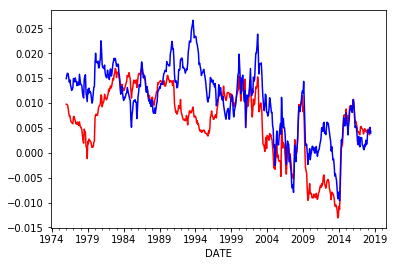

In [23]:
highminuslow1.rolling(60).mean().plot(color='r')
highminuslow3.rolling(60).mean().plot(color='b')
plt.show()

You can see that the last 20 years have been much worse for momentum than the 20 years before.